c:\python37\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "



The best OTSU Threshold:  [57]


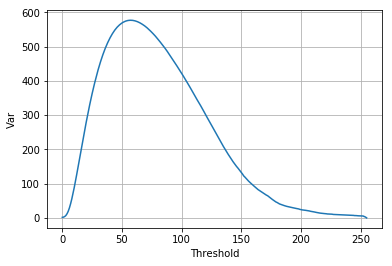

In [1]:
import numpy as np 
import cv2
import math
import matplotlib.pyplot as plt

def Find_Threshold(delta):#OTSU寻找阈值
    # 求灰度方差最大的那个数
    val=np.zeros([256])
    for th in range(256):
        loc1=delta>th
        loc2=delta<=th
        '''delta[loc1]=255
        delta[loc2]=0'''
        if delta[loc1].size==0:
            mu1=0
            omega1=0
        else:
            mu1=np.mean(delta[loc1])
            omega1=delta[loc1].size/delta.size

        if delta[loc2].size==0:
            mu2=0
            omega2=0
        else:
            mu2=np.mean(delta[loc2])
            omega2=delta[loc2].size/delta.size
        val[th]=omega1*omega2*np.power((mu1-mu2),2)

    #print("val=",val.shape)
    plt.figure()
    loc=np.where(val==np.max(val))
    #x=np.arange(0,256,1)
    #x=x.reshape([1,256])
    plt.plot(val)
    plt.ylabel("Var")
    plt.xlabel("Threshold")
    plt.grid("on")

    print("\nThe best OTSU Threshold: ",loc[0])
    return loc[0]

#得到一幅图像的灰度值概率密度，是一个大小256的数组         
def myGetValueProbability(img1):
    # img1 转进来应该是一张灰度图
    #img1 是全黑的   全为0
    #cv2.imshow('diff',img1)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    (row,col)=img1.shape
    p=np.array([0.0 for i in range(256)])
    d0=np.array([0.0 for i in range(256)])
    for i in range(row):
        for j in range(col):
            p[int(img1[i,j])]+=1
    #统计概率
    for i in range(256):
        pp=p[i]
        d0[i]=pp/(row*col)
    
    #返回概率密度
    return d0


def myGetEntropy(img1):
    temp_img=img1
    (row,col)=img1.shape
    entropy=0
    d=myGetValueProbability(temp_img)
    #print(d[:10])
    #dm 可能的最小概率
    dm=1.0/(row*col)/10.0
    
    for i in range(len(d)):
        if d[i]>dm and d[i]<=1:
            l=d[i]
            entropy+=(-l*math.log(l))
    
    return entropy



# 图像的定权 根据熵来更新图片
# isED 决定定权之后是计算欧式距离还是直接线性加权
def MyEntropyWeights(img1,img2,isED):
    # img1 和img2 都是单通道的
    (row,col)=img1.shape
    entropy1 = 0.0
    entropy2 = 0.0
    maritx_temp=np.array([[0.0]*col for i in range(row)])
    # 定义权
    w1=0.0
    w2=0.0
    # 计算熵和权
    entropy1 = myGetEntropy(img1)
    entropy2 =myGetEntropy(img2)
 
    #采用反熵定权，因为数值大小不一样，熵越小权重越大
    w2 = entropy1 / (entropy1 + entropy2)
    w1 = 1 - w2
    
    #基于熵的加权平均
    s1=0.0
    s2=0.0
    tempDN=0.0
    for i in  range(row):
        for j in range(col):
            s1=img1[i,j]
            s2=img2[i,j]
            if isED:
                tempDN=(w1*s1)*(w1*s1) + (w2*s2)*(w2*s2)
                maritx_temp[i,j]=math.sqrt(tempDN)
            else:
                maritx_temp[i,j]=w1*s1 + w2*s2
            
    
    # 再进行一次正则化
    #image = (maritx_temp- np.min(maritx_temp)) / (np.max(maritx_temp) - np.min(maritx_temp))
    image = 255*(maritx_temp-np.min(maritx_temp))/(np.max(maritx_temp)-np.min(maritx_temp))

    th=Find_Threshold(image)
    
    for i1 in range(row):
        for i2 in range(col):
            if image[i1][i2]>=th:
                image[i1][i2]=255
            else:
                image[i1][i2]=0
            
    cv2.imshow('AFS算法',image)
    cv2.imwrite("..\RXX-2020-CVA\Testing dataset\B-landslideAerialImage/AFS.bmp",image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return image

                    
    
    
            
# AFS 代码实现
def AFS(img1,img2):
    (row1,col1,dim1)=img1.shape
    (row2,col2,dim2)=img2.shape
    
    if dim1!=dim2:
        print("维度不同，无法比较")
    temp_img1=img1
    temp_img2=img2
    #创建两个二维矩阵来存放数据
    matrix_CVA = np.array([[0.0]*col1 for i in range(row1)])
    matrix_SAM = np.array([[0.0]*col1 for i in range(row1)])
    
    SAD=0.0  # SAD 存放光谱角
    tagSum=0.0
    tagEum=0.0
    s1=0.0
    s2=0.0
    Ax = 0.0
    Ay1 = 0.0
    Ay2 = 0.0
    Ay3 =0.0
    A=0.0 #A存放余弦值
    # 计算自适应AFS 差值（SAM+CVA）
    for i in range(row1):
        for j in range(col1):
            tagSum=0.0
            Ax=0.0
            Ay1=0.0
            Ay2=0.0
            Ay3=0.0
            A =0.0
            SAD = 0.0            
            for k in range(dim1):
                kk1=int(temp_img1[i,j,k])
                kk2=int(temp_img2[i,j,k]) #向量内积
                Ax+=kk1*kk2
                #print(temp_img1[i,j,k],temp_img2[i,j,k],temp_img1[i,j,k]*temp_img2[i,j,k],i,j,k,Ax)
                Ay1+=int(temp_img1[i,j,k])*int(temp_img1[i,j,k])
                Ay2+=int(temp_img2[i,j,k])*int(temp_img2[i,j,k])
                tagEum=0.0
                s1=int(temp_img1[i,j,k])
                s2=int(temp_img2[i,j,k])
                tagEum=abs(s1-s2)
                tagSum+=tagEum*tagEum
            # 运算完是三个通道的结果
            #tagSum 保存的是差值的平方和
           
            Ay1=math.sqrt(Ay1)
            Ay2=math.sqrt(Ay2)
            Ay3=Ay1*Ay2

            if Ay1==0 or Ay2==0:
                SAD=0
            elif Ax==0: # 内积为0
                SAD=90
            else:
                A=Ax/Ay3
                #print(A)
                AA=abs(A-1)
                if AA<1e-7:
                    SAD=0
                else:
                    SAD=math.acos(A)*180.0/3.1415926
            tagSum=math.sqrt(tagSum)
            
            SAD=2.8*SAD
            matrix_CVA[i,j]=tagSum
            matrix_SAM[i,j]=SAD

            
            
            #归一化 熵的函数后面添加
    matrix_CVA = 255*(matrix_CVA- np.min(matrix_CVA)) / (np.max(matrix_CVA) - np.min(matrix_CVA))            
    matrix_SAM = 255*(matrix_SAM- np.min(matrix_SAM)) / (np.max(matrix_SAM) - np.min(matrix_SAM))

    MyEntropyWeights(matrix_SAM,matrix_CVA,0)  
           
                

                
def getDifferenceImageVectorEDSAD(img1,img2,isHFV):
    (row1,col1,dim1)=img1.shape
    (row2,col2,dim2)=img2.shape
    
    if dim1!=dim2:
        print("维度不同，无法比较")
    temp_img1=img1
    temp_img2=img2
    #创建三个个二维矩阵来存放数据
    Dst=np.array([[0.0]*col1 for i in range(row1)])
    matrix_CVA = np.array([[0.0]*col1 for i in range(row1)])
    matrix_SAM = np.array([[0.0]*col1 for i in range(row1)])
    
    SAD=0.0  # SAD 存放光谱角
    tagSum=0.0
    tagEum=0.0
    s1=0.0
    s2=0.0
    Ax = 0.0
    Ay1 = 0.0
    Ay2 = 0.0
    Ay3 =0.0
    A=0.0 #A存放余弦值
    maxCVA=-10000.0
    maxSAM = -10000.0 # 记录变化矢量和光谱角的最大值
    k=1.0 # 比例系数初值为1
    # 计算自适应AFS 差值（SAM+CVA）
    for i in range(row1):
        for j in range(col1):
            tagSum=0.0
            Ax=0.0
            Ay1=0.0
            Ay2=0.0
            Ay3=0.0
            A =0.0
            SAD = 0.0            
            for k in range(dim1):
                kk1=int(temp_img1[i,j,k])
                kk2=int(temp_img2[i,j,k]) #向量内积
                Ax+=kk1*kk2
                #print(temp_img1[i,j,k],temp_img2[i,j,k],temp_img1[i,j,k]*temp_img2[i,j,k],i,j,k,Ax)
                Ay1+=int(temp_img1[i,j,k])*int(temp_img1[i,j,k])
                Ay2+=int(temp_img2[i,j,k])*int(temp_img2[i,j,k])
                tagEum=0.0
                s1=int(temp_img1[i,j,k])
                s2=int(temp_img2[i,j,k])
                tagEum=abs(s1-s2)
                tagSum+=tagEum*tagEum
            # 运算完是三个通道的结果
            #tagSum 保存的是差值的平方和
           
            Ay1=math.sqrt(Ay1)
            Ay2=math.sqrt(Ay2)
            Ay3=Ay1*Ay2

            if Ay1==0 or Ay2==0:
                SAD=0
            elif Ax==0: # 内积为0
                SAD=90
            else:
                A=Ax/Ay3
                #print(A)
                AA=abs(A-1)
                if AA<1e-7:
                    SAD=0
                else:
                    SAD=math.acos(A)*180.0/3.1415926
            tagSum=math.sqrt(tagSum)
            maxCVA=max(maxCVA,tagSum)
            maxSAM=max(maxSAM,SAD)
            
            #SAD=2.8*SAD
            matrix_CVA[i,j]=tagSum
            matrix_SAM[i,j]=SAD

    if(isHFV):
        k = 255.0 / 90.0
    else:
        if maxSAM!=0:
            k=maxCVA/maxSAM # GCVA
        else:
            k=1
    for i in range(row1):
        for j in range(col1):
            tagSum=0.0
            SAD=0.0
            SAD=k* matrix_SAM[i,j]
            tagSum+=matrix_CVA[i,j]*matrix_CVA[i,j]
            tagSum+=SAD*SAD
            tagSum=math.sqrt(tagSum) #计算GCVA的模长
            Dst[i,j]=tagSum
            

            
            #归一化 熵的函数后面添加
    Dst = 255*(Dst- np.min(Dst)) / (np.max(Dst) - np.min(Dst))
    th=Find_Threshold(Dst)
    
    for i1 in range(row1):
        for i2 in range(col1):
            if Dst[i1][i2]>=th:
                Dst[i1][i2]=255
            else:
                Dst[i1][i2]=0
    cv2.imshow('HFV 算法',Dst)
    cv2.imwrite("..\RXX-2020-CVA\Testing dataset\B-landslideAerialImage/HFV.bmp",Dst)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return Dst

    
    
        
        
  
    
    
    
img1 =cv2.imread(r"C:\Users\dell\Desktop\RXX-2020-CVA\RXX-2020-CVA\Testing dataset\B-landslideAerialImage\2007dopdyssub2B_CopyRaster.tif")                        
img2=cv2.imread(r'C:\Users\dell\Desktop\RXX-2020-CVA\RXX-2020-CVA\Testing dataset\B-landslideAerialImage\2014dopdyssubB_CopyRaster.tif')

#img3=getDifferenceImageVectorEDSAD(img1,img2,True)
img3=AFS(img1,img2)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]